In [1]:
import os 
drive_root = os.getcwd() + '/drive/MyDrive/eecs545project-main'
%cd $drive_root

/content/drive/MyDrive/eecs545project-main


In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision.models as models
from PIL import Image
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.models import inception_v3
from evaluate_dataset import EvaluationDataset
from torch.utils.data import DataLoader
from inception_extractor import PartialInceptionNetwork
from scipy.stats import entropy
from evaluate_dataset import EvaluationDataset
from evaluate import inception_score, FID
from inception_extractor import PartialInceptionNetwork
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


First, create the dataloader. The batch is 1 because we are doing 1 image at a time. For testing purposes, I am using the facades images

In [3]:
# Custom dataset
test_facades = EvaluationDataset(os.path.join(os.getcwd(), 'pokemon'))
# Dataloader
eval_loader = DataLoader(test_facades, batch_size=1)
# Total number of images
N = len(test_facades)
print(N)

['test-0.png', 'test-1.png', 'test-10.png', 'test-100.png', 'test-101.png', 'test-102.png', 'test-103.png', 'test-104.png', 'test-105.png', 'test-106.png', 'test-107.png', 'test-108.png', 'test-109.png', 'test-11.png', 'test-110.png', 'test-111.png', 'test-112.png', 'test-113.png', 'test-114.png', 'test-115.png', 'test-116.png', 'test-117.png', 'test-118.png', 'test-119.png', 'test-12.png', 'test-120.png', 'test-121.png', 'test-122.png', 'test-123.png', 'test-124.png', 'test-125.png', 'test-126.png', 'test-127.png', 'test-128.png', 'test-129.png', 'test-13.png', 'test-130.png', 'test-131.png', 'test-132.png', 'test-133.png', 'test-134.png', 'test-135.png', 'test-136.png', 'test-137.png', 'test-138.png', 'test-139.png', 'test-14.png', 'test-140.png', 'test-141.png', 'test-142.png', 'test-143.png', 'test-144.png', 'test-145.png', 'test-146.png', 'test-147.png', 'test-148.png', 'test-149.png', 'test-15.png', 'test-16.png', 'test-17.png', 'test-18.png', 'test-19.png', 'test-2.png', 'test-2

## Inception Score 
Eq 5 and 6 from https://arxiv.org/pdf/1801.01973.pdf

In [4]:
# Upload the pre-trained inception net
inception_net = inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [5]:
def calculate_inception(dloader, model):
  model.eval()
  phat_y_list = []
  for segment, generated, real in dloader:
    conditional = F.softmax(model(generated)).detach().numpy()
    phat_y_list.append(conditional)
  
  p_yx = np.array(phat_y_list).squeeze(1)
  phat_y = p_yx.mean(axis=0)

  p_y = np.expand_dims(phat_y, 0)
  kl_d = p_yx*(np.log(p_yx + 1e-16) - np.log(p_y+1e-16))
  sum_kl_d = kl_d.sum(axis=1)
  avg_kl_d = np.mean(sum_kl_d)
  is_score = np.exp(avg_kl_d)

  return is_score

calculate_inception(eval_loader, inception_net)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


1.6286455

## FID score

In [6]:
# Define the partial inception model
inception_act = PartialInceptionNetwork()

In [7]:
def FID(model, dloader):
  model.eval()
  activation_generated = []
  for segment, generated, real in dloader:
    output_generated = model(generated).detach().numpy()
    activation_generated.append(output_generated)

  activation_real = []
  for segment, generated, real in dloader:
    output_real = model(real).detach().numpy()
    activation_real.append(output_real)

  act_gen = np.array(activation_generated).squeeze(1)
  act_real = np.array(activation_real).squeeze(1)

  mu_real, mu_fake = act_real.mean(axis=0), act_gen.mean(axis=0)
  cov_real, cov_fake = np.cov(act_real, rowvar=False), np.cov(act_gen, rowvar=False)


  diff = np.linalg.norm(mu_real - mu_fake)**2

  cov_mean = sqrtm(np.matmul(cov_real, cov_fake))

  if np.iscomplexobj(cov_mean):
    cov_mean = cov_mean.real

  fid = diff + np.trace(cov_real + cov_fake -2*cov_mean)

  return fid

FID(inception_act, eval_loader)

44.219443753816805

## FCN score

In [4]:
# Load the model that was trained to make the segmentations
model = models.segmentation.fcn_resnet50(pretrained=True)
model.aux_classifier = models.segmentation.fcn.FCNHead(1024, 13)
model.classifier = models.segmentation.fcn.FCNHead(2048, 13)
model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'fcn_save_200epoch_full'), map_location=torch.device('cpu')))
model.eval()
print()

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [ ]:
def IOU(img1, img2):
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    return sum(intersection)/sum(union)

In [ ]:
def FCNscore(model, dloader):
  model.eval()
  IOU_list = []
  for segment, generated, real in dloader:
    segment_fake = np.array(model(gen)['out'].squeeze(0).argmax(0))
    segment = np.array(segment.squeeze(0)) # assume that this will not have a third channel
    IOU_list.append(IOU(segment_fake, segment))

  return np.mean(np.array(IOU_list))

In [16]:
from skimage.color import label2rgb 
from PIL import Image  
import numpy as np
import matplotlib.pyplot as plt    
import cv2                                           
import os 

In [5]:
segment, gen, real = next(iter(eval_loader))

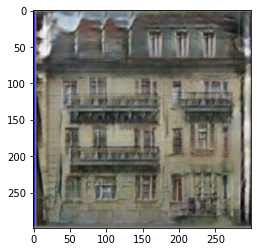

In [6]:
plt.imshow(gen.squeeze(0).permute(1,2,0))

In [39]:
model(gen)['out'].squeeze(0).argmax(0).shape

torch.Size([299, 299])

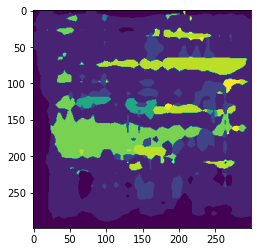

In [7]:
plt.imshow(model(gen)['out'].squeeze(0).argmax(0))

In [41]:
model(gen)['out'].squeeze(0).argmax(0)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

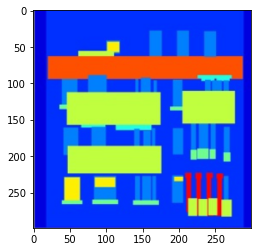

In [9]:
plt.imshow(segment.squeeze(0).permute(1,2,0))

In [44]:
frob_list = []
for seg, gen, real in eval_loader:
  thru_model_color = label2rgb(model(gen)['out'].squeeze(0).argmax(0).numpy())
  seg_truth_altered = seg.squeeze(0).permute(1,2,0).numpy()
  frob_list.append(np.linalg.norm(seg_truth_altered-thru_model_color))

print(np.average(frob_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  This is separate from the ipykernel package so we can avoid doing imports until


281.6715875928606


## Evaluate the sample_images with FID score

This is done by considering the mean image wise instead of as a batch

In [ ]:
def FID_individual(model, dloader):
  model.eval()
  FID_list = []
  for segment, generated, real in dloader:
    output_generated = model(generated).detach().numpy().T
    output_real = model(real).detach().numpy().T

    mu_real, mu_fake = np.mean(output_real, axis = 0), np.mean(output_generated, axis = 0)
    cov_real, cov_fake = np.cov(output_real, rowvar=False), np.cov(output_generated, rowvar=False)

    diff = (mu_real - mu_fake)**2

    cov_mean = np.sqrt(cov_real*cov_fake)

    if np.iscomplexobj(cov_mean):
      cov_mean = cov_mean.real

    fid = diff + cov_real + cov_fake - 2*cov_mean
    FID_list.append(fid)

  return np.array(FID_list).squeeze(1)

candidate_list = FID_individual(inception_act, eval_loader)

In [ ]:
# The minimum distance signifies the best score, the maximum is the worst 
test_facades.get_list()[np.argmin(candidate_list)]

'test-45.png'

In [ ]:
test_facades.get_list()[np.argmax(candidate_list)]

'test-31.png'

## Below are the metrics for the sample images (same images, different epochs)

Above are the metrics for the facades data generation. Below are metrics from epoch examples in the following folders:    
- sample_images_house
- sample_images_lung
- sample_images_facade
- sample_images_city
- sample_images_brain

In [ ]:
# Sample images house 
sample_house = EvaluationDataset(os.path.join(os.getcwd(), 'sample_images_household/sample_images_household'))
# Dataloader
house_loader = DataLoader(sample_house, batch_size=1)
# Total number of images
N = len(sample_house)
print(N)

['test0.png', 'test10.png', 'test100.png', 'test105.png', 'test110.png', 'test115.png', 'test120.png', 'test125.png', 'test130.png', 'test135.png', 'test140.png', 'test15.png', 'test20.png', 'test25.png', 'test30.png', 'test35.png', 'test40.png', 'test45.png', 'test5.png', 'test50.png', 'test55.png', 'test60.png', 'test65.png', 'test70.png', 'test75.png', 'test80.png', 'test85.png', 'test90.png', 'test95.png']
29


In [ ]:
# Pick out the best image 
print("img",sample_house.get_list()[np.argmin(FID_individual(inception_act, house_loader))])
print("best", min(FID_individual(inception_act, house_loader)))
print("worst", max(FID_individual(inception_act, house_loader)))

img test140.png
best 0.0002604127
worst 0.010618269


In [ ]:
# Pick out worst 
sample_house.get_list()[np.argmax(FID_individual(inception_act, house_loader))]

'test35.png'

In [ ]:
# Conclusion --> A "better" generated image came in later epochs which is consistent with what we would expect 

In [ ]:
# Find total FID score and total Inception Score
print("Inception Score", calculate_inception(house_loader, inception_net))
print("FID Score", FID(inception_act, house_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 1.6778027
FID Score 273.16421532301894


In [ ]:
# Sample images house 
sample_lung = EvaluationDataset(os.path.join(os.getcwd(), 'sample_images_lung'))
# Dataloader
lung_loader = DataLoader(sample_lung, batch_size=1)
# Total number of images
N = len(sample_lung)
print(N)

['test0.png', 'test10.png', 'test100.png', 'test105.png', 'test110.png', 'test115.png', 'test120.png', 'test125.png', 'test130.png', 'test135.png', 'test140.png', 'test145.png', 'test15.png', 'test150.png', 'test155.png', 'test160.png', 'test165.png', 'test170.png', 'test175.png', 'test180.png', 'test185.png', 'test190.png', 'test195.png', 'test20.png', 'test25.png', 'test30.png', 'test35.png', 'test40.png', 'test45.png', 'test5.png', 'test50.png', 'test55.png', 'test60.png', 'test65.png', 'test70.png', 'test75.png', 'test80.png', 'test85.png', 'test90.png', 'test95.png']
40


In [ ]:
print("Best image according to FID individual score", sample_lung.get_list()[np.argmin(FID_individual(inception_act, lung_loader))])

Best image according to FID individual score test60.png


In [ ]:
print("Worst score according to FID individual score", sample_lung.get_list()[np.argmax(FID_individual(inception_act, lung_loader))])

Worst score according to FID individual score test160.png


In [ ]:
print("best", min(FID_individual(inception_act, lung_loader)))
print("worst", max(FID_individual(inception_act, lung_loader)))

best 0.0114340335
worst 0.033603266


In [ ]:
# Conclusion --> For the lungs dataset it doesnt work well at all 

In [ ]:
print("Inception Score", calculate_inception(lung_loader, inception_net))
print("FID Score", FID(inception_act, lung_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 1.0
FID Score 289.9649626969089


In [ ]:
# Conclusion --> Comparing the two, we see that the lungs had a lower inception score and higher FID score which means that for both metrics this was worse performing than the housing sample images

In [ ]:
# Sample images facade (epochs)
sample_facade = EvaluationDataset(os.path.join(os.getcwd(), 'sample_images'))
# Dataloader
facade_loader = DataLoader(sample_facade, batch_size=1)
# Total number of images
N = len(sample_facade)
print(N)

['test10.png', 'test100.png', 'test105.png', 'test110.png', 'test115.png', 'test120.png', 'test125.png', 'test130.png', 'test135.png', 'test140.png', 'test145.png', 'test15.png', 'test150.png', 'test155.png', 'test160.png', 'test165.png', 'test170.png', 'test175.png', 'test180.png', 'test185.png', 'test190.png', 'test195.png', 'test20.png', 'test25.png', 'test30.png', 'test35.png', 'test40.png', 'test45.png', 'test50.png', 'test55.png', 'test60.png', 'test65.png', 'test70.png', 'test75.png', 'test80.png', 'test85.png', 'test90.png', 'test95.png']
38


In [ ]:
print("Best image according to FID individual score", sample_facade.get_list()[np.argmin(FID_individual(inception_act, facade_loader))])

Best image according to FID individual score test45.png


In [ ]:
print("Worst image according to FID individual score",sample_lung.get_list()[np.argmax(FID_individual(inception_act, facade_loader))])

Worst image according to FID individual score test85.png


In [ ]:
print("best", min(FID_individual(inception_act, facade_loader)))
print("worst", max(FID_individual(inception_act, facade_loader)))

best 7.778406e-06
worst 0.015932202


In [ ]:
print("Inception Score", calculate_inception(facade_loader, inception_net))
print("FID Score", FID(inception_act, facade_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 2.040591
FID Score 231.89986786195894


In [ ]:
# Sample images cityscapes (epochs)
sample_scapes = EvaluationDataset(os.path.join(os.getcwd(), 'cityscapes_samples/cityscapes'))
# Dataloader
scapes_loader = DataLoader(sample_scapes, batch_size=1)
# Total number of images
N = len(sample_scapes)
print(N)

['test0.png', 'test10.png', 'test100.png', 'test105.png', 'test110.png', 'test115.png', 'test120.png', 'test125.png', 'test130.png', 'test135.png', 'test140.png', 'test145.png', 'test15.png', 'test150.png', 'test155.png', 'test160.png', 'test165.png', 'test170.png', 'test175.png', 'test180.png', 'test185.png', 'test190.png', 'test195.png', 'test20.png', 'test25.png', 'test30.png', 'test35.png', 'test40.png', 'test45.png', 'test5.png', 'test50.png', 'test55.png', 'test60.png', 'test65.png', 'test70.png', 'test75.png', 'test80.png', 'test85.png', 'test90.png', 'test95.png']
40


In [ ]:
print("Best image according to FID individual score", sample_scapes.get_list()[np.argmin(FID_individual(inception_act, scapes_loader))])
print("Worst image according to FID individual score",sample_scapes.get_list()[np.argmax(FID_individual(inception_act, scapes_loader))])

Best image according to FID individual score test35.png
Worst image according to FID individual score test5.png


In [ ]:
print("best", min(FID_individual(inception_act, scapes_loader)))
print("worst", max(FID_individual(inception_act, scapes_loader)))

best 7.778406e-06
worst 0.015932202


In [ ]:
print("Inception Score", calculate_inception(scapes_loader, inception_net))
print("FID Score", FID(inception_act, scapes_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 1.6109173
FID Score 213.13598497238956


In [ ]:
# Sample images cityscapes (epochs)
sample_brain = EvaluationDataset(os.path.join(os.getcwd(), 'brain_sample/mri'))
# Dataloader
brain_sample_loader = DataLoader(sample_brain, batch_size=1)
# Total number of images
N = len(sample_brain)
print(N)

['sample-0.png', 'sample-10.png', 'sample-15.png', 'sample-20.png', 'sample-25.png', 'sample-30.png', 'sample-35.png', 'sample-40.png', 'sample-45.png', 'sample-5.png', 'sample-50.png', 'sample-55.png', 'sample-60.png', 'sample-65.png', 'sample-70.png', 'sample-75.png', 'sample-80.png', 'sample-85.png', 'sample-90.png', 'sample-95.png']
20


In [ ]:
print("Best image according to FID individual score", sample_brain.get_list()[np.argmin(FID_individual(inception_act, brain_sample_loader))])
print("Worst image according to FID individual score",sample_brain.get_list()[np.argmax(FID_individual(inception_act, brain_sample_loader))])

Best image according to FID individual score sample-5.png
Worst image according to FID individual score sample-40.png


In [ ]:
print("best", min(FID_individual(inception_act, brain_sample_loader)))
print("worst", max(FID_individual(inception_act, brain_sample_loader)))

best 0.015190601
worst 0.0544388


In [ ]:
print("Inception Score", calculate_inception(city_loader, inception_net))
print("FID Score", FID(inception_act, city_loader))

## Test images from trained models

- Facades (already done above as the testing for the functions)
- Cityscapes 
- Room
- Lung
- Brain

In [ ]:
# Cityscapes test
sample_city = EvaluationDataset(os.path.join(os.getcwd(), 'cityscapes (1)'))
# Dataloader
city_loader = DataLoader(sample_city, batch_size=1)
# Total number of images
N = len(sample_city)
print(N)

['test-0.png', 'test-1.png', 'test-10.png', 'test-100.png', 'test-101.png', 'test-102.png', 'test-103.png', 'test-104.png', 'test-105.png', 'test-106.png', 'test-107.png', 'test-108.png', 'test-109.png', 'test-11.png', 'test-110.png', 'test-111.png', 'test-112.png', 'test-113.png', 'test-114.png', 'test-115.png', 'test-116.png', 'test-117.png', 'test-118.png', 'test-119.png', 'test-12.png', 'test-120.png', 'test-121.png', 'test-122.png', 'test-123.png', 'test-124.png', 'test-125.png', 'test-126.png', 'test-127.png', 'test-128.png', 'test-129.png', 'test-13.png', 'test-130.png', 'test-131.png', 'test-132.png', 'test-133.png', 'test-134.png', 'test-135.png', 'test-136.png', 'test-137.png', 'test-138.png', 'test-139.png', 'test-14.png', 'test-140.png', 'test-141.png', 'test-142.png', 'test-143.png', 'test-144.png', 'test-145.png', 'test-146.png', 'test-147.png', 'test-148.png', 'test-149.png', 'test-15.png', 'test-150.png', 'test-151.png', 'test-152.png', 'test-153.png', 'test-154.png', '

In [ ]:
print("Best image according to FID individual score", sample_city.get_list()[np.argmin(FID_individual(inception_act, city_loader))])

KeyboardInterrupt: ignored

In [ ]:
print("Worst image according to FID individual score",sample_city.get_list()[np.argmax(FID_individual(inception_act, city_loader))])

Worst image according to FID individual score test-237.png


In [ ]:
print("Inception Score", calculate_inception(city_loader, inception_net))
print("FID Score", FID(inception_act, city_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 1.9994694
FID Score 104.30866534457923


In [ ]:
# Housing test
sample_housing = EvaluationDataset(os.path.join(os.getcwd(), 'households'))
# Dataloader
housing_loader = DataLoader(sample_housing, batch_size=1)
# Total number of images
N = len(sample_housing)
print(N)

['test-0.png', 'test-1.png', 'test-10.png', 'test-11.png', 'test-12.png', 'test-13.png', 'test-14.png', 'test-15.png', 'test-16.png', 'test-17.png', 'test-18.png', 'test-19.png', 'test-2.png', 'test-20.png', 'test-21.png', 'test-22.png', 'test-23.png', 'test-24.png', 'test-25.png', 'test-26.png', 'test-27.png', 'test-28.png', 'test-29.png', 'test-3.png', 'test-30.png', 'test-31.png', 'test-32.png', 'test-33.png', 'test-34.png', 'test-35.png', 'test-36.png', 'test-37.png', 'test-38.png', 'test-39.png', 'test-4.png', 'test-40.png', 'test-41.png', 'test-42.png', 'test-43.png', 'test-44.png', 'test-45.png', 'test-46.png', 'test-47.png', 'test-48.png', 'test-49.png', 'test-5.png', 'test-50.png', 'test-51.png', 'test-52.png', 'test-53.png', 'test-54.png', 'test-55.png', 'test-56.png', 'test-57.png', 'test-58.png', 'test-59.png', 'test-6.png', 'test-60.png', 'test-61.png', 'test-62.png', 'test-63.png', 'test-64.png', 'test-65.png', 'test-66.png', 'test-67.png', 'test-68.png', 'test-69.png', '

In [ ]:
print("Best image according to FID individual score", sample_housing.get_list()[np.argmin(FID_individual(inception_act, housing_loader))])
print("Worst image according to FID individual score",sample_housing.get_list()[np.argmax(FID_individual(inception_act, housing_loader))])
print("Inception Score", calculate_inception(housing_loader, inception_net))
print("FID Score", FID(inception_act, housing_loader))

Best image according to FID individual score test-74.png
Worst image according to FID individual score test-20.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 2.1223025
FID Score 205.35200841732075


In [ ]:
# lungs test
test_lung = EvaluationDataset(os.path.join(os.getcwd(), 'lung'))
# Dataloader
lung_test_loader = DataLoader(test_lung, batch_size=1)
# Total number of images
N = len(test_lung)
print(N)

['test-0.png', 'test-1.png', 'test-10.png', 'test-100.png', 'test-101.png', 'test-102.png', 'test-103.png', 'test-104.png', 'test-105.png', 'test-106.png', 'test-107.png', 'test-108.png', 'test-109.png', 'test-11.png', 'test-110.png', 'test-111.png', 'test-112.png', 'test-113.png', 'test-114.png', 'test-115.png', 'test-116.png', 'test-117.png', 'test-118.png', 'test-119.png', 'test-12.png', 'test-120.png', 'test-121.png', 'test-122.png', 'test-123.png', 'test-124.png', 'test-125.png', 'test-126.png', 'test-127.png', 'test-128.png', 'test-129.png', 'test-13.png', 'test-130.png', 'test-131.png', 'test-132.png', 'test-133.png', 'test-134.png', 'test-135.png', 'test-136.png', 'test-137.png', 'test-138.png', 'test-139.png', 'test-14.png', 'test-140.png', 'test-141.png', 'test-142.png', 'test-143.png', 'test-144.png', 'test-145.png', 'test-146.png', 'test-147.png', 'test-148.png', 'test-149.png', 'test-15.png', 'test-150.png', 'test-151.png', 'test-152.png', 'test-153.png', 'test-154.png', '

In [ ]:
print("Best image according to FID individual score", test_lung.get_list()[np.argmin(FID_individual(inception_act, lung_test_loader))])
print("Worst image according to FID individual score",test_lung.get_list()[np.argmax(FID_individual(inception_act, lung_test_loader))])
print("Inception Score", calculate_inception(lung_test_loader, inception_net))
print("FID Score", FID(inception_act, lung_test_loader))

Best image according to FID individual score test-52.png
Worst image according to FID individual score test-267.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 2.1549785
FID Score 268.66203012456754


In [ ]:
# brain test
sample_brain = EvaluationDataset(os.path.join(os.getcwd(), 'brain/mri'))
# Dataloader
brain_loader = DataLoader(sample_brain, batch_size=1)
# Total number of images
N = len(sample_brain)
print(N)

['test-0.png', 'test-1.png', 'test-10.png', 'test-100.png', 'test-101.png', 'test-102.png', 'test-103.png', 'test-104.png', 'test-105.png', 'test-106.png', 'test-107.png', 'test-108.png', 'test-109.png', 'test-11.png', 'test-110.png', 'test-111.png', 'test-112.png', 'test-113.png', 'test-114.png', 'test-115.png', 'test-116.png', 'test-117.png', 'test-118.png', 'test-119.png', 'test-12.png', 'test-120.png', 'test-121.png', 'test-122.png', 'test-123.png', 'test-124.png', 'test-125.png', 'test-126.png', 'test-127.png', 'test-128.png', 'test-129.png', 'test-13.png', 'test-130.png', 'test-131.png', 'test-132.png', 'test-133.png', 'test-134.png', 'test-135.png', 'test-136.png', 'test-137.png', 'test-138.png', 'test-139.png', 'test-14.png', 'test-140.png', 'test-141.png', 'test-142.png', 'test-143.png', 'test-144.png', 'test-145.png', 'test-146.png', 'test-147.png', 'test-148.png', 'test-149.png', 'test-15.png', 'test-150.png', 'test-151.png', 'test-152.png', 'test-153.png', 'test-154.png', '

In [ ]:
print("Best image according to FID individual score", sample_brain.get_list()[np.argmin(FID_individual(inception_act, brain_loader))])
print("Worst image according to FID individual score",sample_brain.get_list()[np.argmax(FID_individual(inception_act, brain_loader))])
print("Inception Score", calculate_inception(brain_loader, inception_net))
print("FID Score", FID(inception_act, brain_loader))

Best image according to FID individual score test-160.png
Worst image according to FID individual score test-121.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Inception Score 1.0004168
FID Score 302.19078411946634
